# Appendix A5: Bessel low-pass filter ODEs
**Appendix A provides extra background for path clamp electronics.**

In [appendix A4](./appendix-A4-bessel-filters) we explored Bessel filters analytically and filtered signals using SciPy.
In this notebook, we will rewrite some common Bessel filters as ODEs, allowing us to embed them in ODE models.

In particular, we will focus on 2, 4, and 6-pole filters.

- The HEKA EPC-10 uses a 6-pole Bessel filter as part of the voltage-clamp circuitry (filter1), an additional 4-pole Bessel as optional output filtering (filter2, run in series with filter1 for a 10-pole combined filter), and a 2-pole Bessel filter over the command voltage to reduce capacitative transients.
- The HEKA EPC-9 uses a 3-pole Bessel filter (filter1), a 4-pole Bessel filter (filter2), and a 2-pole stimulus filter.
- The Axon Axopatch 200B uses a 4-pole Bessel filter over voltage and a 3-pole Bessel filter over current output.

We'll start simple, with the 1-pole filter.
These results will mainly be useful when we want to approximate a higher-order filter with a first-order one.

## The 1-pole filter

A 1-pole Bessel filter reduces to a basic low-pass filter:
\begin{align}
H_1(s) = \frac{1}{s + 1}
\end{align}

This is easily translated back to an ODE:
\begin{align}
H_1(s) = \frac{Y(s)}{U(s)} = \frac{1}{s + 1} \rightarrow Y(s)(s + 1) = U(s)
\end{align}
for
\begin{align}
\dot{y}(t) + y(t) = u(t), \quad y(0) = 0 \\
\end{align}

To give this filter and adjustable cut-off frequency, we add in a scaling factor $\alpha$:
\begin{align}
H_1(s) = \frac{1}{\alpha s + 1}
\end{align}
for
\begin{align}
\dot{y}(t) = \frac{u(t) - y(t)}{\alpha}
\end{align}
So in this case $\alpha$ is a time constant (we'll see below that it gets slightly more complex for higher order filters).

The cut-off frequency of a filter is usually defined as the point where _the magnitude of its frequency response_, given by $|H(i\phi)|$, equals $1/\sqrt{2}$ (approximately -3dB).
So we write out the magnitude to find
\begin{align}
|H_1(i\phi)| = \left| \frac{1}{1 + \alpha\phi i} \right| = \frac{1}{\sqrt{1 + \alpha^2\phi^2}}
\end{align}
which equals $1/\sqrt{2}$ when
\begin{align}
\alpha^2\phi_c^2 = 1 \quad \rightarrow \quad \alpha = 1 / \phi_c
\end{align}
where the last step is okay because $\alpha$ and $\phi_c$ are both real, positive numbers.

This means that, for $\alpha = 1$ the cut-off frequency is 1 rad/sec, and for any other $\alpha$ the cut-off is $1/\alpha$ rad/sec.
For a cut-off in Hz, we get:
\begin{align}
\alpha = \frac{1}{2 \pi f_c}
\end{align}


We can now write a 1-pole Bessel filter with cut-off $f_c$ as:

In [1]:
import myokit
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

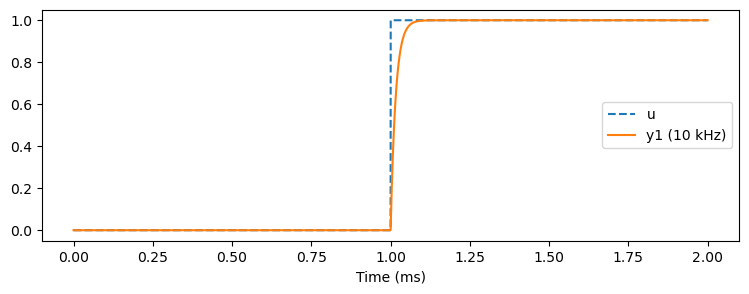

In [2]:
m = myokit.parse_model("""
[[model]]
filter.y1 = 0

[filter]
pace = 0 bind pace
time = 0 bind time
fc = 10
alpha = 1 / (2 * 3.14159 * fc)
dot(y1) = (pace - y1) / alpha
""")

p = myokit.Protocol()
p.schedule(start=1, duration=10, level=1)

s = myokit.Simulation(m, p)
d1 = s.run(2, log_interval=0.0001)

fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot()
ax.set_xlabel('Time (ms)')
ax.plot(d1.time(), d1['filter.pace'], '--', label='u')
ax.plot(d1.time(), d1['filter.y1'], label='y1 (10 kHz)')
ax.legend(loc='right')
plt.show()

Note that we've been cheeky and have omitted the units: time is in ms, which means the model's `fc` variable is in kHz.

### Rise time

We can work out a rise time for this model by writing out the solution of the ODE for a step from 0 to 1, occuring at t=0:

\begin{align}
y(t) = 1 - e^{-t/\alpha}
\end{align}

Defining the rise time as the time from $y(t1)=0.1$ to $y(t2)=0.9$ we find
\begin{align}
t_1 &= -\alpha \log(1 - 0.1) \\
t_2 &= -\alpha \log(1 - 0.9) \\
t_r &= t_2 - t_1 = \alpha \log(9)
\end{align}

Which lets us relate alpha, rise time, and cut-off frequency as:
\begin{align}
\alpha &= \frac{t_r}{\log 9} = \frac{1}{2 \pi f_c} 
\quad \rightarrow \quad
f_c = \frac{\log 9}{2 \pi t_r}
\end{align}

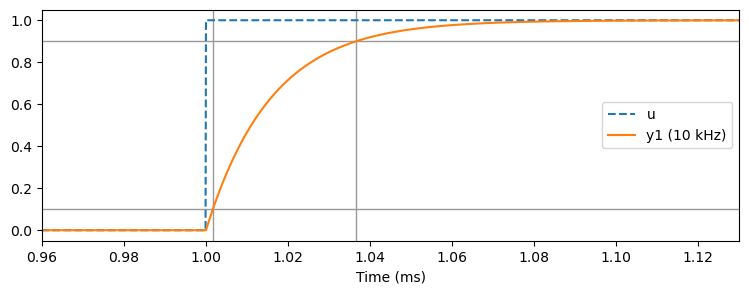

In [3]:
alpha = 1 / (2 * 3.14159 * 10)
t1 = -alpha * np.log(0.9)
t2 = -alpha * np.log(0.1)

fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot()
ax.set_xlabel('Time (ms)')
kw = dict(lw=1, color='#999')
ax.axhline(0.1, **kw)
ax.axhline(0.9, **kw)
ax.axvline(1 + t1, **kw)
ax.axvline(1 + t2, **kw)
ax.plot(d1.time(), d1['filter.pace'], '--', label='u')
ax.plot(d1.time(), d1['filter.y1'], label='y1 (10 kHz)')
ax.legend(loc='right')
ax.set_xlim(0.96, 1.13)
plt.show()

### Comparison with SciPy

Finally, we check if SciPy agrees with what we've done:

In [4]:
def low_pass(time, data, f, n=3):
    """ Emulate an analog Bessel low-pass filter with cut-off f in Hz. """
    b, a = scipy.signal.bessel(n, 2 * np.pi * f, analog=True, norm='mag')
    t, y, _ = scipy.signal.lsim((b, a), data, time)
    return t, y

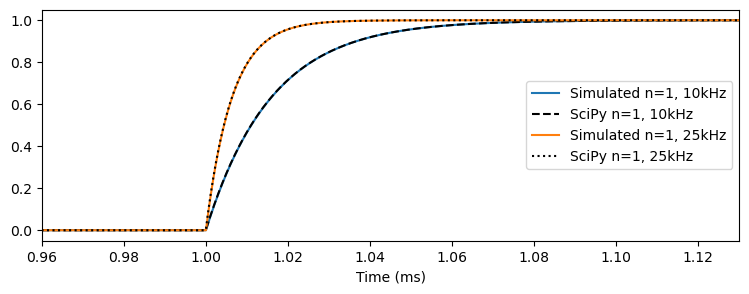

In [5]:
s.reset()
s.set_constant('filter.fc', 25)
d2 = s.run(2, log_interval=0.0001)

fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot()
ax.set_xlabel('Time (ms)')
kw = dict(lw=1, color='#999')
ax.plot(d1.time(), d1['filter.y1'], label='Simulated n=1, 10kHz')
ax.plot(*low_pass(d1.time(), d1['filter.pace'], 10, 1), 'k--', label='SciPy n=1, 10kHz')
ax.plot(d2.time(), d2['filter.y1'], label='Simulated n=1, 25kHz')
ax.plot(*low_pass(d1.time(), d1['filter.pace'], 25, 1), 'k:', label='SciPy n=1, 25kHz')
ax.legend(loc='right')
ax.set_xlim(0.96, 1.13)
plt.show()

## The 2-pole Bessel filter

We can find an ODE form for the 2-pole Bessel filter by working out an inverse Laplace transform.
The filter's transfer function
\begin{align}
H(s) = \frac{Y(s)}{U(s)} &= \frac{3}{s^2 + 3s + 3}
\end{align}
can be rewritten as
\begin{align}
s^2Y(s) + 3sY(s) + 3Y(s) &= 3U(s)
\end{align}
which corresponds to
\begin{align}
\ddot{y}(t) + 3 \dot{y}(t) + 3 y(t) = 3 u(t), && \dot{y}(0)=0, && y(0)=0
\end{align}

To convert this to a system of first-order ODEs, we choose $y_2 = y$ and $y_1 = \dot{y}$ to find
\begin{align}
\dot{y_1} &= 3(u(t) - y_2 - y_1) \\
\dot{y_2} &= y_1
\end{align}
Note that $y = y_2(t)$ here is the final variable of interest, representing the filter's output.

Let's try it out!

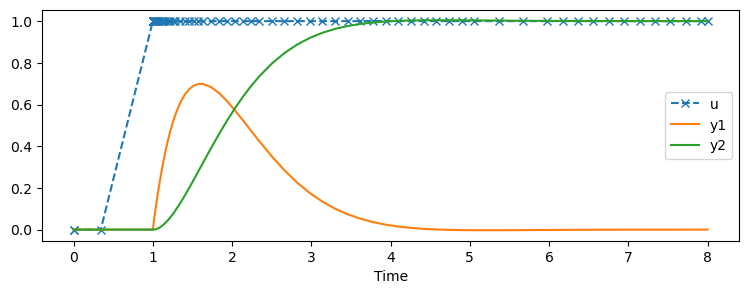

In [6]:
m = myokit.parse_model("""
[[model]]
f.y1 = 0
f.y2 = 0

[f]
pace = 0 bind pace
time = 0 bind time
dot(y1) = 3 * (pace - y2 - y1)
dot(y2) = y1
""")

p = myokit.Protocol()
p.schedule(start=1, duration=10, level=1)

s = myokit.Simulation(m, p)
e = s.run(8)

fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot()
ax.set_xlabel('Time')
ax.plot(e.time(), e['f.pace'], 'x--', label='u')
ax.plot(e.time(), e['f.y1'], label='y1')
ax.plot(e.time(), e['f.y2'], label='y2')
ax.legend(loc='right')
plt.show()

Next, we make it tuneable by adding a scaling factor:

\begin{align}
H(s) = \frac{3}{(\alpha s)^2 + 3\alpha s + 3}
\end{align}
for
\begin{align}
\ddot{y}(t) = \frac{3}{\alpha^2} u(t) - \frac{3}{\alpha^2} y(t) - \frac{3}{\alpha} \dot{y}(t)
\end{align}

This scaling factor will change the filter's frequency, relative to its _natural frequency_ (the $\alpha = 1$ case).
To find the natural cut-off, we can try solving $|H_2(i\phi)|=1/\sqrt{2}$, but it's easier* to just use rootfinding:

(*See [Appendix 4](./appendix-A4-bessel-filters.ipynb) for some background on the scipy functions involved.)

In [7]:
def bessel_natural_cutoff(n):
    b, a = scipy.signal.bessel(n, 1, analog=True, norm='delay')
    m = lambda w: np.abs(scipy.signal.freqs(b, a, worN=[w])[1])
    e = lambda w: (m(w) - 1 / np.sqrt(2))**2
    w = scipy.optimize.fmin(e, [1], disp=False)[0]
    assert(abs(m(w) - 1 / np.sqrt(2)) < 1e-3)
    return w

print(f'{bessel_natural_cutoff(2):.5} rad/sec')

1.3616 rad/sec


This means we can set $\alpha$ using a cut-off frequency $f_c$ (in Hz) as:

\begin{align}
\alpha = \frac{1.3616}{2 \pi f_c}
\end{align}

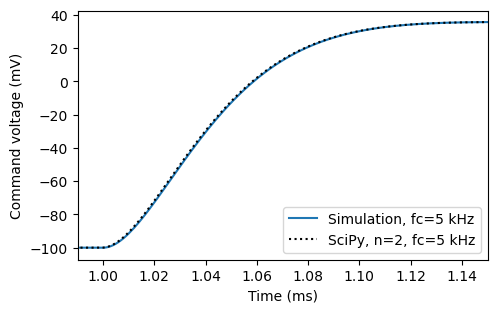

In [8]:
m = myokit.parse_model("""
[[model]]
filter.y1 = 0
filter.y2 = 0

[filter]
pace = 0 bind pace
time = 0 bind time
fc = 1
alpha = 1.3616 / (2 * 3.14159 * fc)
dot(y1) = 3 * (pace/alpha^2 - y2/alpha^2 - y1/alpha)
dot(y2) = y1
""")

p = myokit.Protocol()
p.add_step(level=-100, duration=1)
p.add_step(level=35, duration=10)

fc = 5
s = myokit.Simulation(m, p)
s.set_constant('filter.fc', fc)
s.pre(1)
d1 = s.run(2, log_interval=1e-3).npview()

fig = plt.figure(figsize=(5, 3))
fig.subplots_adjust(0.14, 0.15, 0.96, 0.98)
ax = fig.add_subplot()
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Command voltage (mV)')
ax.plot(d1.time(), d1['filter.y2'], label=f'Simulation, fc={fc} kHz')
ax.plot(*low_pass(d1.time(), d1['filter.pace'], fc, 2), 'k:', label=f'SciPy, n=2, fc={fc} kHz')
ax.legend()
ax.set_xlim(0.99, 1.15)
plt.show()

We can also relate this to the first-order rise time, by setting it to the same cut-off frequency:

\begin{align}
\alpha = \frac{1.3616}{2 \pi f_c} = \frac{1.3616}{2 \pi \log(9) / (2 \pi t_r)} = \frac{1.3616}{\log(9)}t_r
\end{align}

In [9]:
fc = np.log(9) / (2 * np.pi * 0.04)
print(fc)

8.742478814151495


This lets us compare 1st and 2nd order filters with the recordings from an EPC-10 again (see [appendix A4](./Appendix-A4-bessel-filters)):

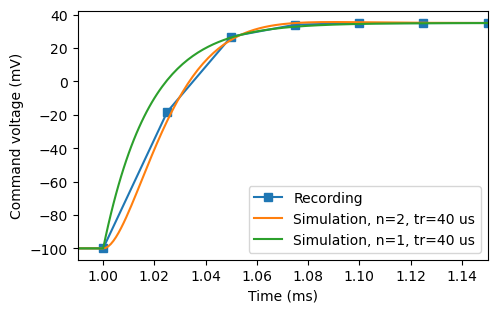

In [10]:
# Load the "20us" data, which appears to have a rise time of 40us instead
d0 = myokit.DataLog.load('resources/rise_time_20us.zip')
d0 = d0.npview()

m = myokit.parse_model("""
[[model]]
filter.y1 = 0
filter.y2 = 0
filter.y3 = 0

[filter]
pace = 0 bind pace
time = 0 bind time
tr = 0.04 [ms] in [ms]
# Second-order
a2 = tr * 1.3616 / log(9)
    in [ms]
dot(y1) = 3 * (pace/a2^2 - y2/a2^2 - y1/a2)
dot(y2) = y1
# First-order
a1 = tr / log(9)
    in [ms]
dot(y3) = (pace - y3) / a1
""")

p = myokit.Protocol()
p.add_step(level=-100, duration=1)
p.add_step(level=35, duration=10)

s = myokit.Simulation(m, p)
s.pre(1)
d1 = s.run(2, log_interval=1e-3).npview()

fig = plt.figure(figsize=(5, 3))
fig.subplots_adjust(0.14, 0.15, 0.96, 0.98)
ax = fig.add_subplot()
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Command voltage (mV)')
ax.plot(d0.time(), d0['vfiltered'], 's-', label='Recording')
ax.plot(d1.time(), d1['filter.y2'], label=f'Simulation, n=2, tr=40 us')
ax.plot(d1.time(), d1['filter.y3'], label=f'Simulation, n=1, tr=40 us')
ax.legend()
ax.set_xlim(0.99, 1.15)
plt.show()

### Third-order Bessel

The third order Bessel filter is given by
\begin{align}
H_3(s) &= \frac{15}{s^3 + 6s^2 + 15s + 15}
\end{align}

Instead of working with this expression directly, we'll write it in terms of its _poles_.
These can be looked up in tables, or obtained from SciPy:

In [11]:
zeroes, poles, gain = scipy.signal.bessel(3, 1, output='zpk', analog=True, norm='delay')
print(f'Zeroes: {zeroes}')
print('Poles:')
for pole in poles:
    print(f'  {pole}')
print(f'Gain: {gain}')

Zeroes: []
Poles:
  (-1.838907322686957+1.754380959783721j)
  (-2.3221853546260856-0j)
  (-1.838907322686957-1.754380959783721j)
Gain: 15.0


Note that the first and last form a conjugate pair.
These conjugate pairs appear in all Bessel filters with 2 or more poles.
By definition, Bessel filters never have any zeroes.

Using the pole-zero representation, we can write the filter as
\begin{align}
H_3(s) &= 15 \frac{1}{s + \sigma_2} \, \frac{1}{(s + \sigma_1 - \omega_1 i)(s + \sigma_1 + \omega_1 i)} \\
       &= 15 \frac{1}{s + \sigma_2} \, \frac{1}{s^2 + (2 \sigma_1) s + (\sigma_1^2 + \omega_1^2)}
\end{align}
where we represented each pole as either $-\sigma$ (real) or $-\sigma \pm \omega$.

By design $\sigma_2 \cdot (\sigma_1^2 + \omega_1^2)$ equals the gain $K = 15$, which means we can write
\begin{align}
H_3(s) = \frac{\sigma_2}{s + \sigma_2} \frac{\sigma_1^2 + \omega_1^2}{s^2 + (2 \sigma_1) s + (\sigma_1^2 + \omega_1^2)}
\end{align}

This shows that we can write a 3-pole bessel as the product of a first and a second-order filter.
As a result, we can treat it **as two filters in series** (see [Appendix A2](./appendix-A2-laplace-and-filters.ipynb) "Block diagrams").
In fact, the standard way to create a 2n-pole filter in electronics, is to build a _cascade_ of n 2-pole filters placed in series.
So this should be similar to what we find in real amplifiers.

To find the various numbers involved, we'll use SciPy again:

In [12]:
s1, w1, s2 = -poles[0].real, poles[0].imag, -poles[1].real
print(f'sigma2 = {s2:.5}')
print(f'2 sigma1 = {2 * s1:.5}')
print(f'(sigma1^2 + omega1^2) = {s1**2 + w1**2:.5}')

sigma2 = 2.3222
2 sigma1 = 3.6778
(sigma1^2 + omega1^2) = 6.4594


And with these we can break down the 3-pole low-pass Bessel filter into a first-order filter
\begin{align}
H(s) = \frac{2.3222}{s + 2.3222} && \rightarrow && \dot{y} = \frac{u(t) - y(t)}{1 / 2.32}
\end{align}
and a second order filter
\begin{align}
H(s) = \frac{6.4594}{s^2 + 3.6778s + 6.4594}
&& \rightarrow && 
\ddot{y}(t) = 6.4594u(t) - 3.6778\dot{y}(t) - 6.4594y(t),\quad y(0)=0, \quad \dot{y}(0)=0
\end{align}

Let's try it out.

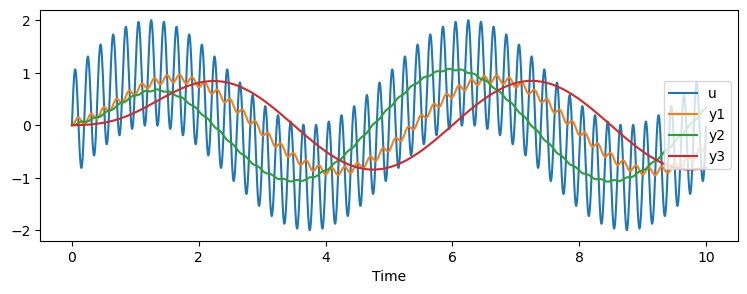

In [13]:
m = myokit.parse_model("""
[[model]]
f.y1 = 0
f.y2 = 0
f.y3 = 0

[f]
t = 0 bind time
u = sin(2 * 3.14159 * t / 5) + sin(2 * 3.14159 * t * 5)
dot(y1) = (u - y1) * 2.3222
dot(y2) = 6.4594 * (y1 - y3) - 3.6778 * y2
dot(y3) = y2
    desc: The 3-pole filtered output
""")
s = myokit.Simulation(m)
e = s.run(10, log_interval=0.001)

fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot()
ax.set_xlabel('Time')
ax.plot(e.time(), e['f.u'], label='u')
ax.plot(e.time(), e['f.y1'], label='y1')
ax.plot(e.time(), e['f.y2'], label='y2')
ax.plot(e.time(), e['f.y3'], label='y3')
ax.legend(loc='right')
plt.show()

Is this correct?
We can compare with a SciPy filtered signal to find out, but first we'll need to work out what the natural cut-off frequency for this filter is.

In [14]:
print(f'{bessel_natural_cutoff(3):.5} rad/sec')
print(f'{bessel_natural_cutoff(3) / (2 * np.pi):.5} Hz')

1.7557 rad/sec
0.27942 Hz


We didn't apply any scaling in the simulation, so this should be a 0.2794 Hz filter:

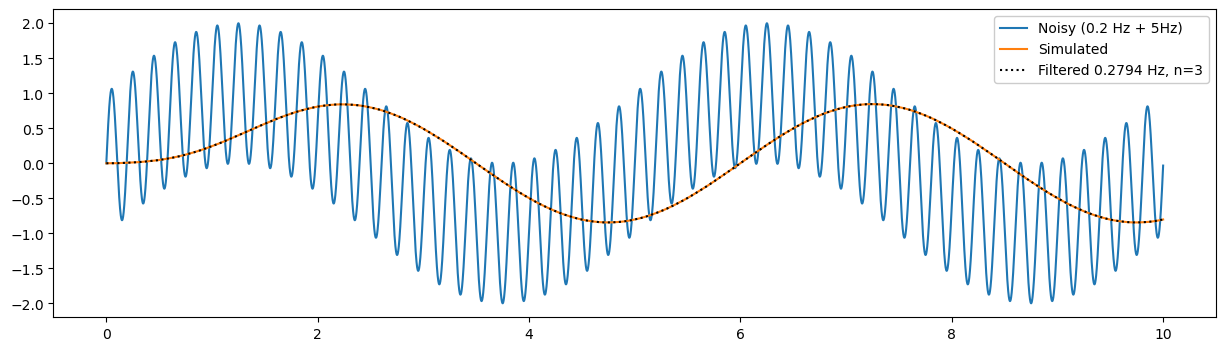

In [15]:
t, u, y = e.time(), e['f.u'], e['f.y3']

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(t, u, label='Noisy (0.2 Hz + 5Hz)')
ax.plot(t, y, label='Simulated')
ax.plot(*low_pass(t, u, f=0.2794, n=3), 'k:', label='Filtered 0.2794 Hz, n=3')
ax.legend(framealpha=1)
plt.show()

Note that we obtained the pole information in the "natural" setting by calling `bessel` with `Wn=1, norm='delay'`.
Here `Wn` is interpreted as a parameter related to "group delay" and the canonical results are obtained for `Wn=1`.
But we filtered using `Wn=w, norm='mag'`.
Here `Wn` is interpreted as the cut-off frequency.
Alternatively, we could have used the "natural" call again, to obtain an unscalable filter:

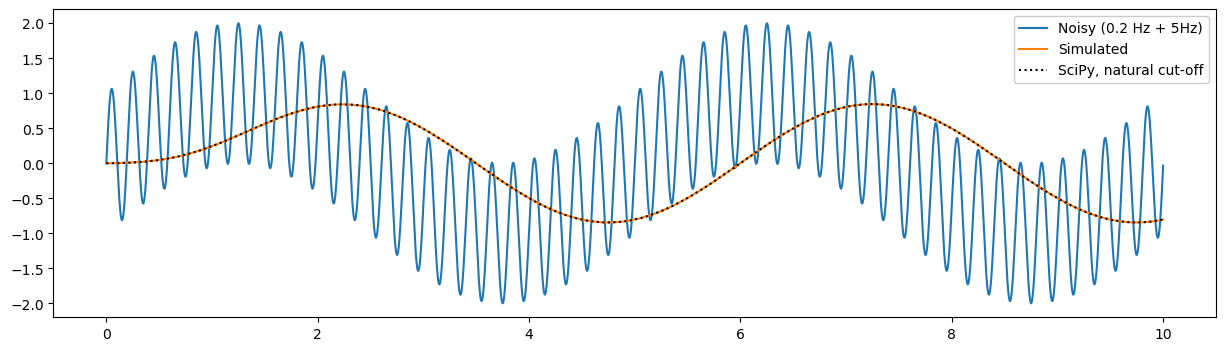

In [16]:
def low_pass_natural(time, data, n=3):
    """ Emulate an analog Bessel low-pass filter with its natural cut-off point. """
    b, a = scipy.signal.bessel(n, 1, analog=True, norm='delay')
    t, y, _ = scipy.signal.lsim((b, a), data, time)
    return t, y

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(t, u, label='Noisy (0.2 Hz + 5Hz)')
ax.plot(t, y, label='Simulated')
ax.plot(*low_pass_natural(t, u, n=3), 'k:', label='SciPy, natural cut-off')
ax.legend(framealpha=1)
plt.show()

### Fourth-order Bessel, and general Bessel filters with an even number of poles

Based on the idea of decomposing higher order filters, we can now write down the equations for a 4 pole filter, along with the more general equations for Bessel low-pass filters with an even number of poles.

\begin{align}
H_4(s) &= \frac{105}{s^4 + 10s^3 + 45s^2 + 105s + 105} \\
       &= \prod_i^2 \frac{\sigma_i^2 + \omega_i^2}{s^2 + 2 \sigma_i s + \sigma_i^2 + \omega_i^2}
\end{align}
Giving a cascade of two filters:
\begin{align}
\ddot{y_i}(t) = (\sigma_i^2 + \omega_i^2)(u(t) - y(t)) - 2\sigma_i\dot{y}(t),\quad y_i(0)=0, \quad \dot{y_i}(0)=0
\end{align}
Where $-\sigma_i \pm \omega_i$ are the 2 conjugate pole pairs.

More generally for any even number of poles $n = 2m$
\begin{align}
H_{2m}(s) &= \prod_i^m \frac{\sigma_i^2 + \omega_i^2}{s^2 + 2 \sigma_i s + \sigma_i^2 + \omega_i^2} \\
\end{align}

In [17]:
def even_poles(n):
    _, p, _ = scipy.signal.bessel(n, 1, output='zpk', analog=True, norm='delay')
    for k, p in enumerate(p[:n // 2]):
        s, w = -p.real, p.imag
        print(f'2 sigma_{1 + k} = {2 * s:.5}')
        print(f'(sigma_{1 + k}^2 + omega_{1 + k}^2) = {s**2 + w**2:.5}')

print(even_poles(4))

2 sigma_1 = 4.2076
(sigma_1^2 + omega_1^2) = 11.488
2 sigma_2 = 5.7924
(sigma_2^2 + omega_2^2) = 9.1401
None


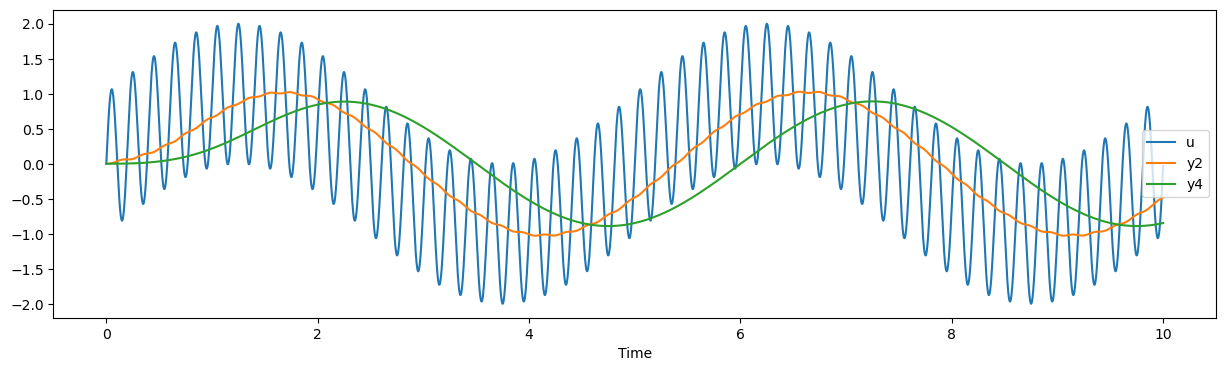

In [18]:
m = myokit.parse_model("""
[[model]]
f.y1 = 0
f.y2 = 0
f.y3 = 0
f.y4 = 0

[f]
t = 0 bind time
u = sin(2 * 3.14159 * t / 5) + sin(2 * 3.14159 * t * 5)
dot(y1) = 11.488 * (u - y2) - 4.2076 * y1
dot(y2) = y1
dot(y3) = 9.1401 * (y2 - y4) - 5.7924 * y3
dot(y4) = y3
    desc: The 4-pole filtered output
""")
s = myokit.Simulation(m)
e = s.run(10, log_interval=0.001)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.set_xlabel('Time')
ax.plot(e.time(), e['f.u'], label='u')
ax.plot(e.time(), e['f.y2'], label='y2')
ax.plot(e.time(), e['f.y4'], label='y4')
ax.legend(loc='right')
plt.show()

Before working out the natural frequency and scaling, we'll just compare with the natural version returned by SciPy:

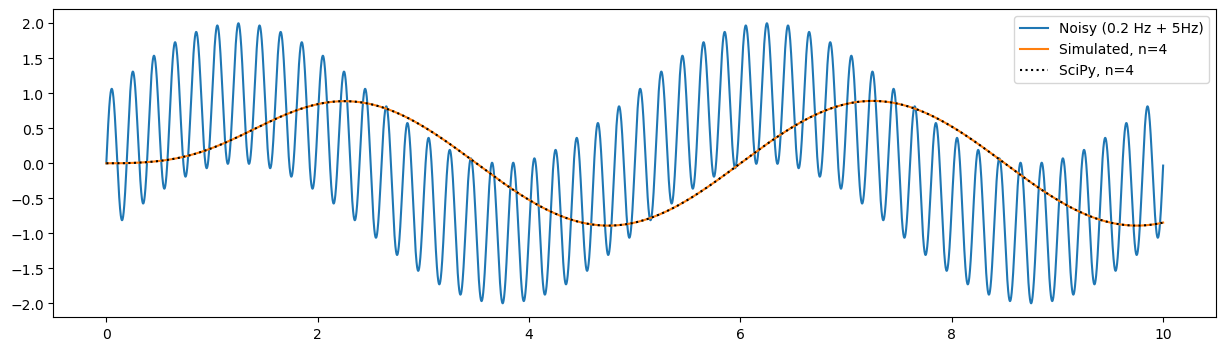

In [19]:
t, u, y = e.time(), e['f.u'], e['f.y4']

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(t, u, label='Noisy (0.2 Hz + 5Hz)')
ax.plot(t, y, label='Simulated, n=4')
ax.plot(*low_pass_natural(t, u, n=4), 'k:', label='SciPy, n=4')
ax.legend()
plt.show()

Looks exactly right.

#### Scalable filter with even number of poles

Finally, we'll work out how to make this 4-pole filter scalable, and write the results in a way that extends to any even-numbered order low-pass Bessel filter.

To do this, we add a scaling factor $\alpha$ to every $s$
\begin{align}
H_{2m}(s) &= \prod_i^m \frac{\sigma_i^2 + \omega_i^2}{(\alpha s)^2 + 2 \sigma_i (\alpha s) + \sigma_i^2 + \omega_i^2} \\
\end{align}
to find
\begin{align}
\ddot{y_i}(t) = \frac{\sigma_i^2 + \omega_i^2}{\alpha^2}(u(t) - y(t)) - \frac{2\sigma_i}{\alpha}\dot{y}(t)
\end{align}
where
\begin{align}
\alpha = \frac{\omega_0}{2 \pi f}
\end{align}
where $\omega_0$ is the unscaled cut-off frequency in rad/sec and where $f$ is the desired cut-off frequency in Hz.

We can find $\omega_0$ using SciPy and fmin:

In [20]:
print(f'{bessel_natural_cutoff(4):.5} rad/sec')

2.114 rad/sec


Let's try it in a model:

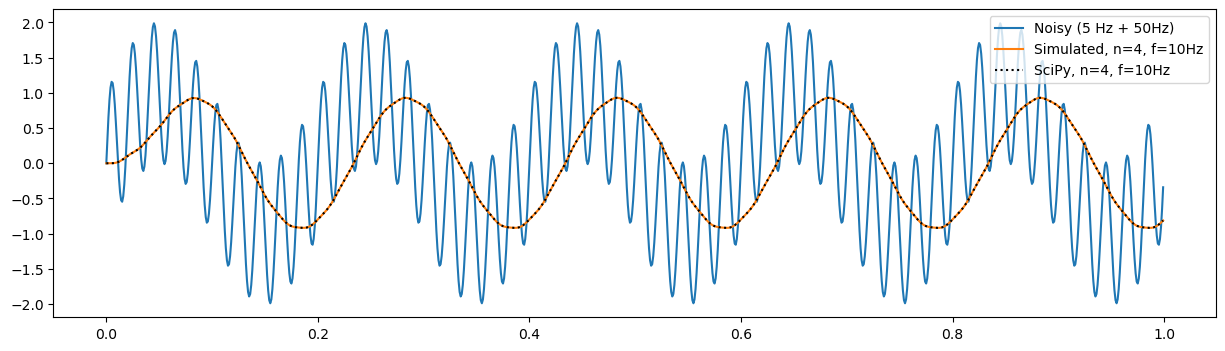

In [21]:
m = myokit.parse_model("""
[[model]]
f.y1 = 0
f.y2 = 0
f.y3 = 0
f.y4 = 0

[f]
t = 0 bind time
pi = 3.14159
u = sin(2 * pi * 5 * t) + sin(2 * pi * 50 * t)
f = 10 [Hz]
alpha = 2.114 / (2 * pi * f)
dot(y1) = 11.488 / alpha^2 * (u - y2) - 4.2076 / alpha * y1
dot(y2) = y1
dot(y3) = 9.1401 / alpha^2 * (y2 - y4) - 5.7924 / alpha * y3
dot(y4) = y3
    desc: The 4-pole filtered output
""")
s = myokit.Simulation(m)
e = s.run(1, log_interval=0.001)

t, u, y = e.time(), e['f.u'], e['f.y4']

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(t, u, label='Noisy (5 Hz + 50Hz)')
ax.plot(t, y, label='Simulated, n=4, f=10Hz')
ax.plot(*low_pass(t, u, 10, n=4), 'k:', label='SciPy, n=4, f=10Hz')
ax.legend()
plt.show()

Looks great!

### Six pole Bessel filters

Applying the same methods for a six pole filter we obtain:

In [22]:
print(even_poles(6))

2 sigma_1 = 5.0319
(sigma_1^2 + omega_1^2) = 26.514
2 sigma_2 = 7.4714
(sigma_2^2 + omega_2^2) = 20.853
2 sigma_3 = 8.4967
(sigma_3^2 + omega_3^2) = 18.801
None


In [23]:
print(f'{bessel_natural_cutoff(6):.5} rad/sec')

2.7034 rad/sec


We can find $\omega_0$ using SciPy and fmin:

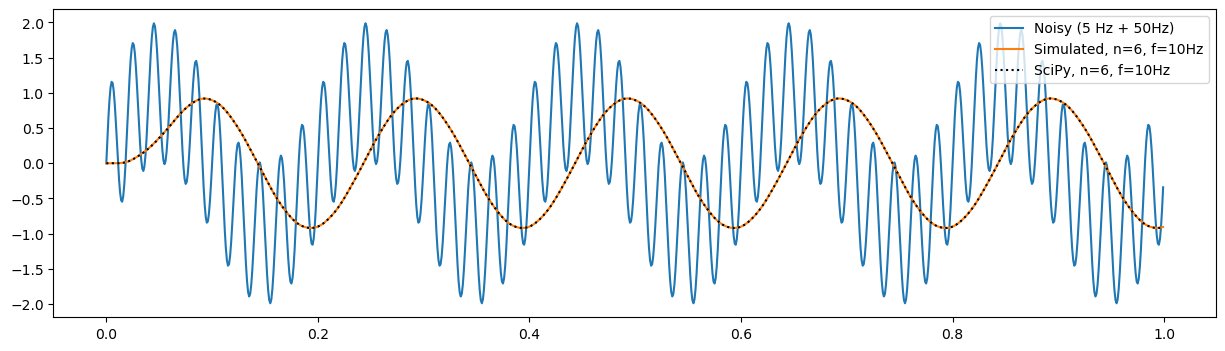

In [24]:
m = myokit.parse_model("""
[[model]]
f.y1 = 0
f.y2 = 0
f.y3 = 0
f.y4 = 0
f.y5 = 0
f.y6 = 0

[f]
t = 0 bind time
pi = 3.14159
u = sin(2 * pi * 5 * t) + sin(2 * pi * 50 * t)
f = 10 [Hz]
alpha = 2.7034 / (2 * pi * f)
dot(y1) = 26.514 / alpha^2 * (u - y2) - 5.0319 / alpha * y1
dot(y2) = y1
dot(y3) = 20.853 / alpha^2 * (y2 - y4) - 7.4714 / alpha * y3
dot(y4) = y3
dot(y5) = 18.801 / alpha^2 * (y4 - y6) - 8.4967 / alpha * y5
dot(y6) = y5
    desc: The 6-pole filtered output
""")
s = myokit.Simulation(m)
e = s.run(1, log_interval=0.001)
t, u, y = e.time(), e['f.u'], e['f.y6']

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(t, u, label='Noisy (5 Hz + 50Hz)')
ax.plot(t, y, label='Simulated, n=6, f=10Hz')
ax.plot(*low_pass(t, u, 10, n=6), 'k:', label='SciPy, n=6, f=10Hz')
ax.legend()
plt.show()

It works!

## First-order approximations

Finally, we compare a 6-pole filter with a 1-pole approximation.

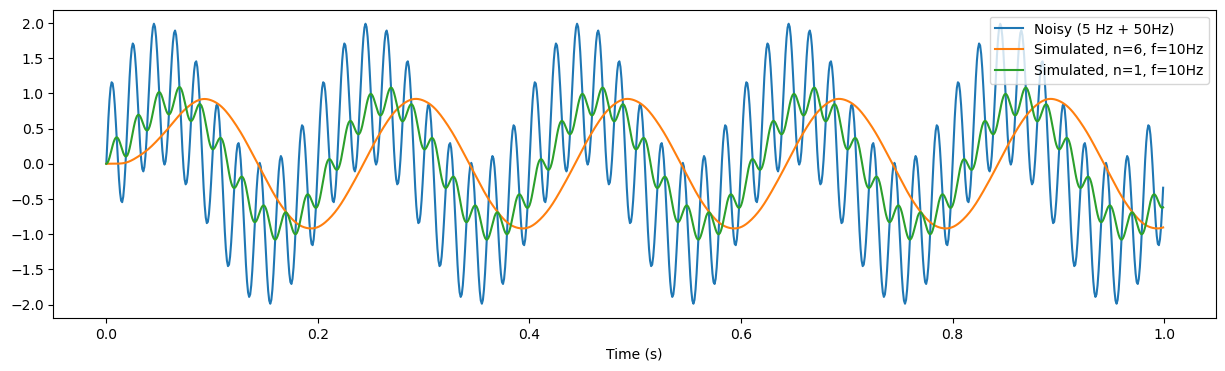

In [25]:
m = myokit.parse_model("""
[[model]]
f.y1 = 0
f.y2 = 0
f.y3 = 0
f.y4 = 0
f.y5 = 0
f.y6 = 0
f.z1 = 0

[f]
t = 0 bind time
p = 0 bind pace
pi = 3.14159
u = sin(2 * pi * 5 * t) + sin(2 * pi * 50 * t)
f = 10 [Hz]
a1 = 1 / (2 * pi * f)
a6 = 2.7034 / (2 * pi * f)
dot(y1) = 26.514 / a6^2 * (u - y2) - 5.0319 / a6 * y1
dot(y2) = y1
dot(y3) = 20.853 / a6^2 * (y2 - y4) - 7.4714 / a6 * y3
dot(y4) = y3
dot(y5) = 18.801 / a6^2 * (y4 - y6) - 8.4967 / a6 * y5
dot(y6) = y5
    desc: The 6-pole filtered output
dot(z1) = (u - z1) / a1
    desc: The 1-pole filtered output
""")
s = myokit.Simulation(m)
e = s.run(1, log_interval=0.001)
t, u, y, z = e.time(), e['f.u'], e['f.y6'], e['f.z1']

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.set_xlabel('Time (s)')
ax.plot(t, u, label='Noisy (5 Hz + 50Hz)')
ax.plot(t, y, label='Simulated, n=6, f=10Hz')
ax.plot(t, z, label='Simulated, n=1, f=10Hz')
ax.legend()
plt.show()

The 1-pole filter doesn't filter out the high frequencies as well, but has considerably less lag.
_However_, for patch-clamping we're much more interested in the step response:

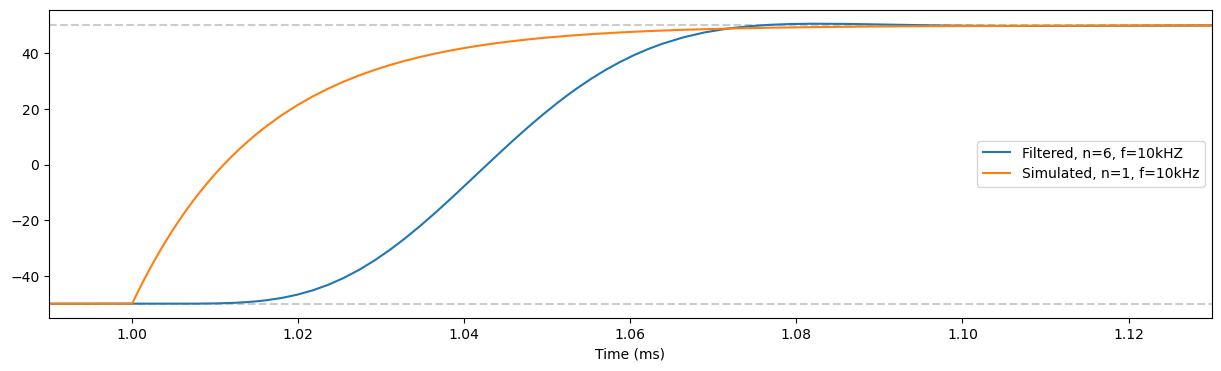

In [26]:
# Update the model to use pacing
# We also re-interpret time as being in ms, making the frequency 10 kHz
m.get('f.u').set_rhs('p')
p = myokit.Protocol()
p.add_step(level=-50, duration=1)
p.add_step(level=50, duration=1)
s = myokit.Simulation(m, p)
s.pre(1)
e = s.run(2)
t, u, y, z = e.time(), e['f.u'], e['f.y6'], e['f.z1']

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.set_xlabel('Time (ms)')
ax.axhline(-50, color='#ccc', ls='--')
ax.axhline(+50, color='#ccc', ls='--')
ax.plot(t, y, label='Filtered, n=6, f=10kHZ')
ax.plot(t, z, label='Simulated, n=1, f=10kHz')
ax.set_xlim(0.99, 1.13)
ax.legend()
plt.show()

Here we can see the much faster response of the 1-pole filter, and the much smoother response of the 6-pole.
The phase-shift in the 6-pole causes a notable delay in the jump.

The effects are very shortlived though, so we're unlikely to notice this until we sample at a high rate and really zoom in.
At 10kHz, the filters seem unlikely to have a big effect on any currents.